In [31]:
import cv2
import sys
import math
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors

MAP_SIZE = 50
max_val = MAP_SIZE

EMPTY = 0
OCCUPIED = 1
EXPANDED = 2
INCUBATION = 3

In [32]:
def create_empty_plot(max_val):
    """
    For plotting matters
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax

In [33]:
def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [34]:
def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

In [35]:
def A_Star(start, goal, h, coords, occupancy_grid, max_val=MAP_SIZE):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    
    movements = _get_movements_8n()
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet

In [36]:
def get_image():
    filename = 'input_picture_2.png'
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    
    return img

In [37]:
def expand_grid(occupancy_grid):
    
    nb_exp_turn = 2   
    
    for i in range(nb_exp_turn):
        occupancy_grid = expandation_turn(occupancy_grid)
        occupancy_grid = incubation_turn(occupancy_grid)
    
    return occupancy_grid

In [38]:
def expandation_turn(occupancy_grid):
    
    for i in range(MAP_SIZE):
        for j in range(MAP_SIZE):
            if(occupancy_grid[i,j]==OCCUPIED or occupancy_grid[i,j]==EXPANDED):
                
                if(j==0):
                    L_col = j
                else:
                    L_col = j-1

                if(i==0):
                    T_line = i
                else:
                    T_line = i-1

                if(j==MAP_SIZE-1):
                    R_col = j
                else:
                    R_col = j+1

                if(i==MAP_SIZE-1):
                    B_line = i
                else:
                    B_line = i+1

                TL = [T_line, L_col]
                T = [T_line, j]
                TR = [T_line, R_col]
                ML = [i, L_col]
                MR = [i, R_col]
                BL = [B_line, L_col]
                B = [B_line, j]
                BR = [B_line, R_col]

                boxes_to_test = [TL, T, TR, ML, MR, BL, B, BR]
                
                for k in boxes_to_test:
                    if(occupancy_grid[k[0],k[1]]==EMPTY):
                        occupancy_grid[k[0],k[1]]=INCUBATION
                        
    return occupancy_grid

In [39]:
def incubation_turn(occupancy_grid):

    for i in range(MAP_SIZE):
        for j in range(MAP_SIZE):
            if(occupancy_grid[i,j]==INCUBATION):
                occupancy_grid[i,j]=EXPANDED
                
    return occupancy_grid

In [40]:
def get_occupancy_grid(img):

    np.set_printoptions(threshold=sys.maxsize)

#     filename = 'input_picture_2.png'
#     img = cv2.imread(filename, cv2.IMREAD_COLOR)

    grayImage = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(grayImage, (MAP_SIZE,MAP_SIZE), interpolation = cv2.INTER_AREA) 

    height, width = resized.shape[:2] # Size of the map
    # fig, ax = create_empty_plot(width)

    ret,thresh1 = cv2.threshold(resized,90,255,cv2.THRESH_BINARY_INV)

    # plt.figure(figsize=(30,50))
    # plt.subplot(121),plt.imshow(img[:,:,::-1])
    # plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    # plt.subplot(122),plt.imshow(thresh1,cmap = 'gray')
    # plt.title('Threshold Image'), plt.xticks([]), plt.yticks([])
    #data = np.random.rand(max_val, max_val) * 20

    # cmap = colors.ListedColormap(['white', 'red'])
    occupancy_grid = thresh1.copy()
    occupancy_grid = occupancy_grid/255
    occupancy_grid = np.array(occupancy_grid, dtype=int)
    occupancy_grid = np.flip(occupancy_grid, 0)
    occupancy_grid = occupancy_grid.transpose()
    occupancy_grid = expand_grid(occupancy_grid)

    # ax.imshow(occupancy_grid, cmap=cmap)
    # plt.title("Map : free cells in white, occupied cells in red");

    # plt.show()
    occupancy_grid = np.array(occupancy_grid)
    
    return occupancy_grid

In [41]:
def get_data(img):
    original_height, original_width = img.shape[:2]

    # resized = cv2.resize(img, (MAP_SIZE,MAP_SIZE), interpolation = cv2.INTER_AREA) 
    # plt.figure(figsize=(30,50))
    # plt.subplot(121),plt.imshow(img[:,:,::-1])
    # plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    # plt.subplot(122),plt.imshow(resized[:,:,::-1])
    # plt.title('Resized Image'), plt.xticks([]), plt.yticks([])

    # plt.show

    ##################### GOAL ##########################
    template_goal = img[605:689,600:685,:]
    # plt.figure()
    # plt.imshow(template_goal[:,:,::-1])
    # plt.show()

    #c, w, h  = template_goal.shape[::-1]
    res = cv2.matchTemplate(img,template_goal,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # plt.imshow(res)
    # plt.title('Matching Image'), plt.xticks([]), plt.yticks([])

    goal = min_loc
    x_goal=int(np.round(goal[0]*MAP_SIZE/original_width))
    y_goal=MAP_SIZE-int(np.round(goal[1]*MAP_SIZE/original_height)) #confirm height and width
    goal = (x_goal, y_goal)
    # print("Position of the goal [x, y] :", goal)

    ##################### ROBOT ##########################
    template_red_point = img[75:95,45:65,:]
    # plt.figure()
    # plt.imshow(template_red_point[:,:,::-1])
    # plt.show()

    res = cv2.matchTemplate(img,template_red_point,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # plt.imshow(res)
    # plt.title('Matching Image'), plt.xticks([]), plt.yticks([])

    red = [min_loc[0], min_loc[1]]
    red[1] = original_height-red[1]
    #print("Position of the red point [x, y] :", red)


    template_yellow_point = img[90:110,70:90,:]
    # plt.figure()
    # plt.imshow(template_yellow_point[:,:,::-1])
    # plt.show()

    res = cv2.matchTemplate(img,template_yellow_point,cv2.TM_SQDIFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # plt.imshow(res)
    # plt.title('Matching Image'), plt.xticks([]), plt.yticks([])

    yellow = [min_loc[0], min_loc[1]]
    yellow[1] = original_height-yellow[1]
    #print("Position of the yellow point [x, y] :", yellow)

    ############ Compute pos and orientation ############

    x=(red[0]+yellow[0])/2
    y=(red[1]+yellow[1])/2
    x=int(np.round(x*MAP_SIZE/original_width))
    y=int(np.round(y*MAP_SIZE/original_height))

    v = [red[0]-yellow[0], red[1]-yellow[1]]

    theta = math.atan2(v[1],v[0])

    robot_pose = [x, y, theta]
    start = (x,y)
    # print("Position of the robot [x, y, theta] :", robot_pose)
    
    return robot_pose, start, goal

In [42]:
def findroute(start, goal, occupancy_grid):
    x,y = np.mgrid[0:max_val:1, 0:max_val:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])

    h = np.linalg.norm(pos - goal, axis=-1)
    h = dict(zip(coords, h))

    path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid)
    path = np.array(path).reshape(-1, 2).transpose()
    visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()
    
    return path, visitedNodes

In [51]:
def plot_map(visitedNodes, path, start, goal, occupancy_grid):
    cmap = colors.ListedColormap(['white', 'black', 'red'])
    fig_astar, ax_astar = create_empty_plot(max_val)
    ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
    ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
    ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
    ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);
    return

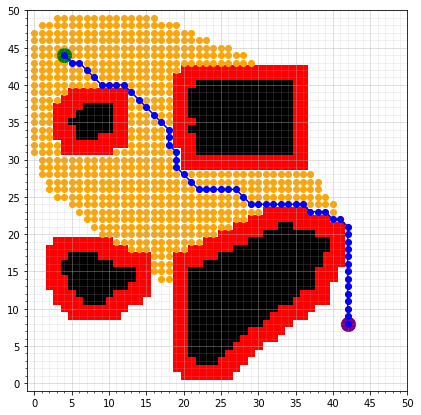

In [52]:
# Main:

# Get a picture of the map
img = get_image()

# Get obstacle's postions
occupancy_grid = get_occupancy_grid(img)

# Get robot and goal's positions
(robot_pos, start, goal) = get_data(img)

# Find a route
path, visitedNodes = findroute(start, goal, occupancy_grid)

# Plot everything
plot_map(visitedNodes, path, start, goal, occupancy_grid)